# Analiza i Wizualizacja Danych z Czujników
##  1. Wprowadzenie
 Ten notebook służy do analizy i wizualizacji danych zebranych z symulowanych czujników. Dane są odczytywane z plików logów CSV generowanych przez moduł `Logger`. Wykorzystamy biblioteki Pandas do manipulacji danymi, Matplotlib i Seaborn do tworzenia wykresów, Numpy do operacji numerycznych oraz Scipy do zaawansowanych statystyk.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import sys

# Założenie: notebook znajduje się w głównym katalogu projektu.
# Dodajemy katalog projektu do ścieżki, aby umożliwić import modułu logger.
# Jeśli logger.py jest w tym samym katalogu co notebook, to nie jest to ściśle konieczne,
# ale jest to dobra praktyka.
# project_root = os.path.abspath(os.getcwd())
# if project_root not in sys.path:
#    sys.path.insert(0, project_root)

try:
    from logger import Logger
except ImportError:
    print("Nie można zaimportować modułu Logger. Upewnij się, że plik logger.py znajduje się w odpowiednim miejscu.")
    Logger = None

# Konfiguracja Matplotlib do wyświetlania wykresów w linii w Jupyter
get_ipython().run_line_magic('matplotlib', 'inline')
plt.style.use('seaborn-v0_8-whitegrid') # Użycie stylu seaborn dla estetyczniejszych wykresów
sns.set_theme(style="whitegrid")

## 2. Ładowanie Konfiguracji i Inicjalizacja Loggera

In [3]:
# Ścieżka do pliku konfiguracyjnego loggera
logger_config_path = "config.json" # Zakładamy, że plik jest w głównym katalogu projektu

logger_instance = None
if Logger:
    try:
        logger_instance = Logger(config_path=logger_config_path)
        print(f"Logger zainicjalizowany. Katalog logów: {logger_instance.log_dir}")
        # logger_instance.start() # Start nie jest potrzebny do odczytu, ale upewnia się, że struktura katalogów istnieje
        # logger_instance.stop() # Zamykamy od razu, jeśli start() otworzył plik
    except FileNotFoundError:
        print(f"KRYTYCZNY BŁĄD: Plik konfiguracyjny loggera '{logger_config_path}' nie został znaleziony.")
    except Exception as e:
        print(f"Błąd podczas inicjalizacji loggera: {e}")
else:
    print("Klasa Logger nie została zaimportowana.")

Logger zainicjalizowany. Katalog logów: ./logs


## 3. Ładowanie Danych z Czujników
 Użyjemy metody `read_logs` z naszej klasy `Logger` do załadowania danych. Metoda ta pozwala na filtrowanie danych według zakresu dat oraz identyfikatora czujnika.


In [4]:
df_sensors = pd.DataFrame()

if logger_instance:
    # Definicja zakresu czasowego do załadowania danych
    # Na przykład, załaduj dane z ostatnich 7 dni
    end_dt = datetime.now()
    start_dt = end_dt - timedelta(days=7) # Możesz dostosować ten zakres

    print(f"Próba załadowania logów od {start_dt.strftime('%Y-%m-%d %H:%M:%S')} do {end_dt.strftime('%Y-%m-%d %H:%M:%S')}")

    try:
        log_entries = list(logger_instance.read_logs(start_dt=start_dt, end_dt=end_dt))

        if not log_entries:
            print("Nie znaleziono wpisów w logach dla podanego okresu.")
        else:
            df_sensors = pd.DataFrame(log_entries)
            print(f"Pomyślnie załadowano {len(df_sensors)} wpisów z logów.")
    except Exception as e:
        print(f"Błąd podczas ładowania logów: {e}")
        # df_sensors pozostanie pusty
else:
    print("Logger nie został zainicjalizowany. Nie można załadować danych.")

Próba załadowania logów od 2025-05-31 23:33:16 do 2025-06-07 23:33:16
Pomyślnie załadowano 1520 wpisów z logów.


## 4. Eksploracja i Przygotowanie Danych
Wyświetlimy podstawowe informacje o ramce danych, sprawdzimy typy danych i dokonamy niezbędnych konwersji.

In [5]:
if not df_sensors.empty:
    print("Podstawowe informacje o DataFrame:")
    df_sensors.info()

    print("\nPierwsze 5 wierszy danych:")
    print(df_sensors.head())

    # Konwersja typów danych, jeśli to konieczne
    # Metoda read_logs powinna już zwracać 'timestamp' jako datetime i 'value' jako float.
    if 'timestamp' in df_sensors.columns:
        df_sensors['timestamp'] = pd.to_datetime(df_sensors['timestamp'])

    if 'value' in df_sensors.columns:
        df_sensors['value'] = pd.to_numeric(df_sensors['value'], errors='coerce')

    # Usunięcie wierszy z brakującymi wartościami w kluczowych kolumnach
    df_sensors.dropna(subset=['timestamp', 'value', 'sensor_id'], inplace=True)

    # Ustawienie kolumny 'timestamp' jako indeksu (przydatne do analizy szeregów czasowych)
    if 'timestamp' in df_sensors.columns:
        df_sensors.set_index('timestamp', inplace=True)
        df_sensors.sort_index(inplace=True) # Sortowanie po indeksie czasowym

    print("\nInformacje o DataFrame po przetworzeniu:")
    df_sensors.info()

    print("\nPierwsze 5 wierszy danych po przetworzeniu:")
    print(df_sensors.head())

    # Unikalne identyfikatory czujników
    if 'sensor_id' in df_sensors.columns:
        unique_sensor_ids = df_sensors['sensor_id'].unique()
        print(f"\nZnalezione unikalne ID czujników: {unique_sensor_ids}")
    else:
        unique_sensor_ids = []
        print("\nKolumna 'sensor_id' nie została znaleziona.")
else:
    print("Ramka danych jest pusta. Pomijanie eksploracji i przygotowania danych.")
    unique_sensor_ids = []

Podstawowe informacje o DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  1520 non-null   datetime64[ns]
 1   sensor_id  1520 non-null   object        
 2   value      1520 non-null   float64       
 3   unit       1520 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 47.6+ KB

Pierwsze 5 wierszy danych:
                   timestamp sensor_id    value unit
0 2025-06-07 21:47:53.071876    temp01    39.56   °C
1 2025-06-07 21:47:53.072879     hum01    19.70    %
2 2025-06-07 21:47:53.073877   press01  1020.75  hPa
3 2025-06-07 21:47:53.073877   light01    37.00   lx
4 2025-06-07 21:47:54.075519    temp01    40.04   °C

Informacje o DataFrame po przetworzeniu:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1520 entries, 2025-06-07 21:47:53.071876 to 2025-06-07 22:05:29.

## 5. Statystyki Opisowe
Obliczymy i wyświetlimy podstawowe statystyki dla każdego czujnika.

In [6]:
if not df_sensors.empty and 'sensor_id' in df_sensors.columns and 'value' in df_sensors.columns:
    print("\nStatystyki opisowe dla wartości odczytów pogrupowane po ID czujnika:")
    # Użycie reset_index() aby sensor_id był kolumną do grupowania, jeśli timestamp jest indeksem
    grouped_stats = df_sensors.reset_index().groupby('sensor_id')['value'].agg(['mean', 'median', 'min', 'max', 'std', 'count'])
    print(grouped_stats)

    # Wykorzystanie Scipy do obliczenia dodatkowych statystyk (np. skośność, kurtoza)
    from scipy import stats

    print("\nSzczegółowe statystyki (w tym Scipy) dla każdego czujnika:")
    for sensor_id_val in unique_sensor_ids:
        sensor_data = df_sensors[df_sensors['sensor_id'] == sensor_id_val]['value']
        if not sensor_data.empty:
            print(f"\nStatystyki dla czujnika: {sensor_id_val}")
            print(f"  Średnia: {np.mean(sensor_data):.2f}")
            print(f"  Mediana: {np.median(sensor_data):.2f}")
            print(f"  Odch. std.: {np.std(sensor_data):.2f}")
            print(f"  Min: {np.min(sensor_data):.2f}")
            print(f"  Max: {np.max(sensor_data):.2f}")
            print(f"  Skośność: {stats.skew(sensor_data):.2f}")
            print(f"  Kurtoza (Fisher): {stats.kurtosis(sensor_data):.2f}") # Kurtoza Fishera (dla rozkładu normalnego = 0)
        else:
            print(f"\nBrak danych dla czujnika {sensor_id_val} do obliczenia statystyk Scipy.")
else:
    print("Ramka danych jest pusta lub brakuje wymaganych kolumn ('sensor_id', 'value'). Pomijanie statystyk opisowych.")


Statystyki opisowe dla wartości odczytów pogrupowane po ID czujnika:
                 mean  median     min      max        std  count
sensor_id                                                       
hum01       28.383684   24.25    5.90    96.10  18.506964    380
light01     25.315789   25.50    1.00    50.00  14.044981    380
press01    984.671237  983.50  950.82  1021.20  12.419469    380
temp01      30.537053   31.67    0.00    40.17   6.659238    380

Szczegółowe statystyki (w tym Scipy) dla każdego czujnika:

Statystyki dla czujnika: temp01
  Średnia: 30.54
  Mediana: 31.67
  Odch. std.: 6.65
  Min: 0.00
  Max: 40.17
  Skośność: -3.01
  Kurtoza (Fisher): 11.41

Statystyki dla czujnika: hum01
  Średnia: 28.38
  Mediana: 24.25
  Odch. std.: 18.48
  Min: 5.90
  Max: 96.10
  Skośność: 2.03
  Kurtoza (Fisher): 4.91

Statystyki dla czujnika: press01
  Średnia: 984.67
  Mediana: 983.50
  Odch. std.: 12.40
  Min: 950.82
  Max: 1021.20
  Skośność: 0.88
  Kurtoza (Fisher): 4.96

Statystyki

## 6. Wizualizacja Danych
Stworzymy wykresy, aby zwizualizować odczyty z czujników w czasie oraz ich rozkłady.

### 6.1 Wykresy Szeregów Czasowych dla Każdego Czujnika


Generowanie wykresów szeregów czasowych...


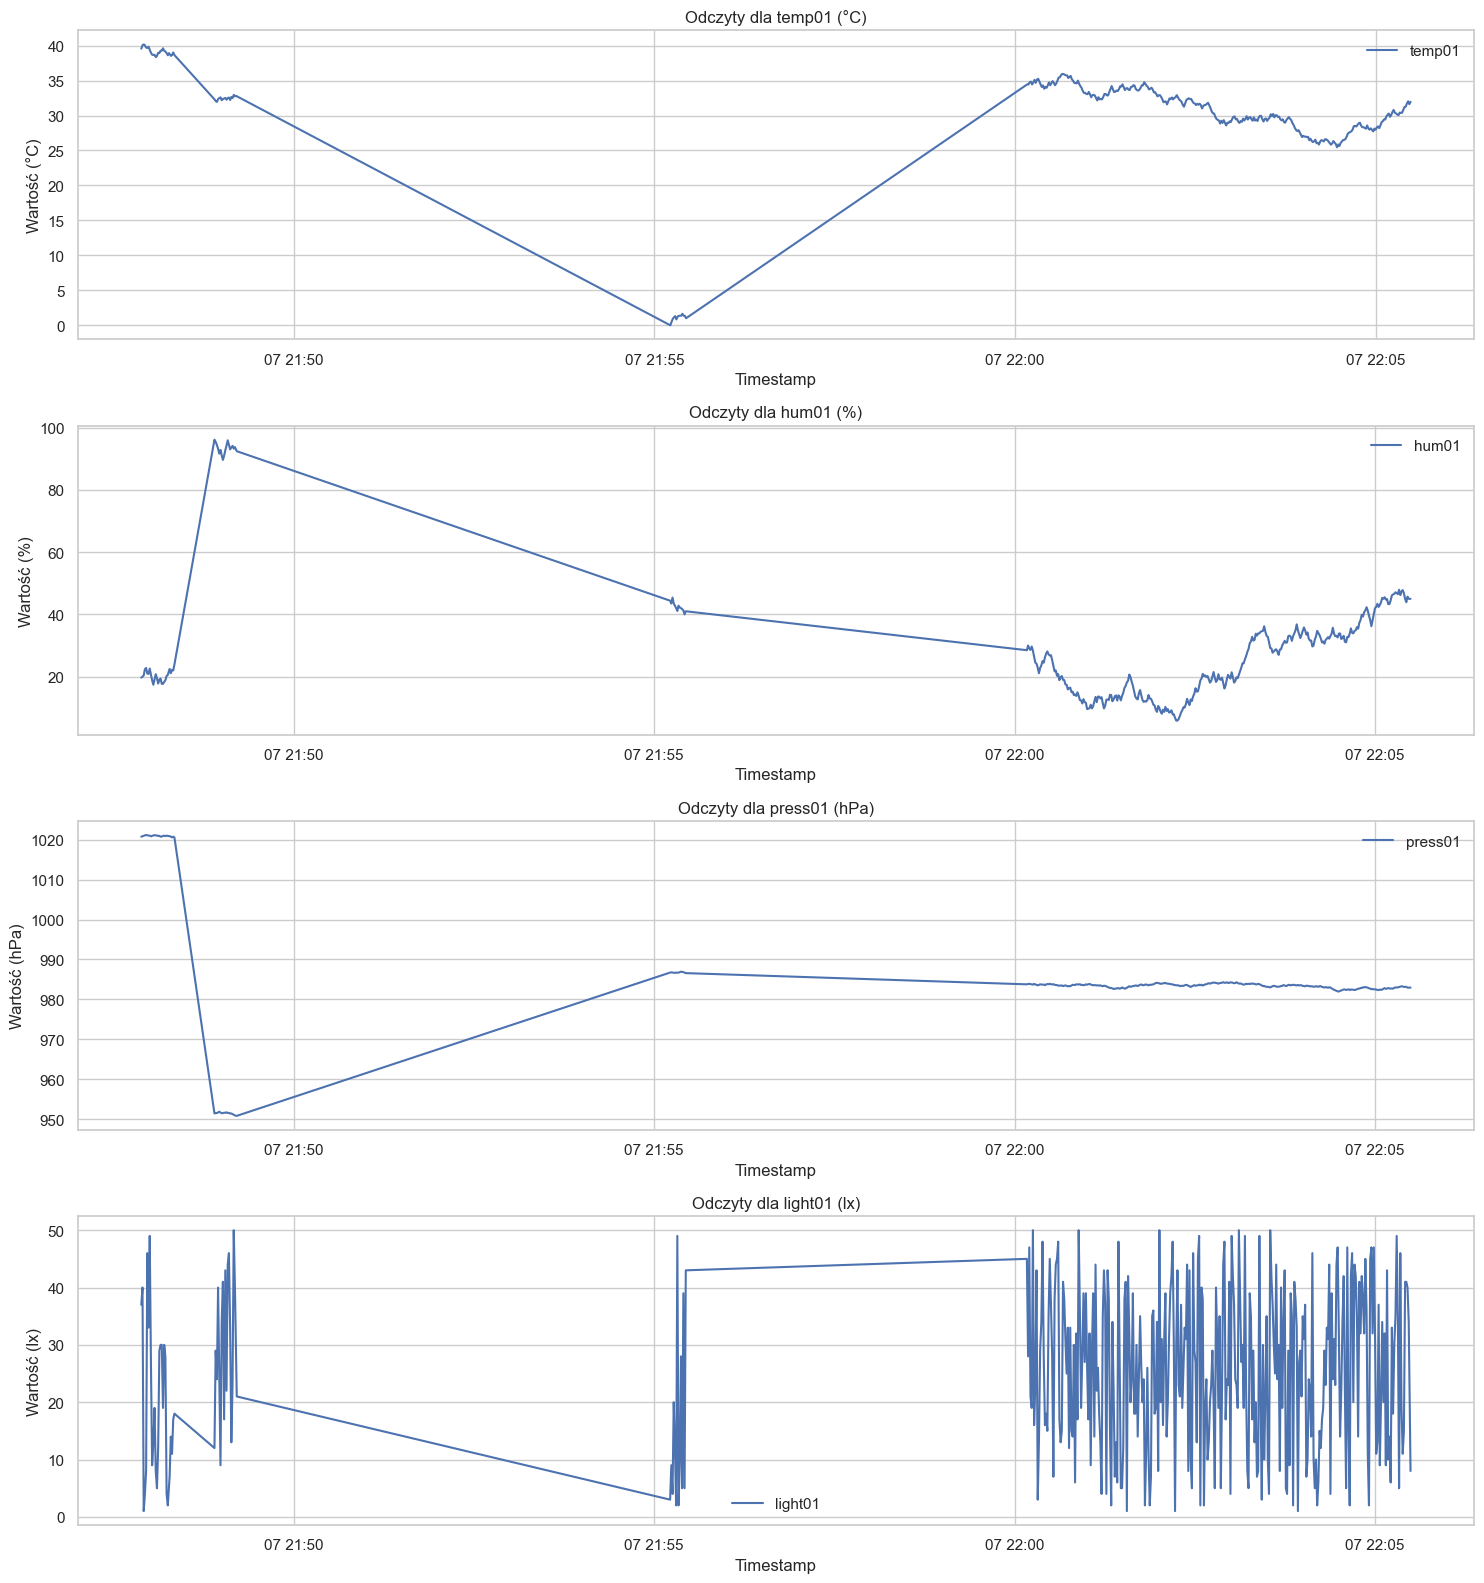

In [8]:
if not df_sensors.empty and 'sensor_id' in df_sensors.columns and len(unique_sensor_ids) > 0:
    print("\nGenerowanie wykresów szeregów czasowych...")
    num_sensors = len(unique_sensor_ids)

    # Dynamiczne określenie rozmiaru figury
    fig_height = num_sensors * 4
    if fig_height < 5: fig_height = 5 # Minimalna wysokość
    if fig_height > 20: fig_height = 20 # Maksymalna rozsądna wysokość

    plt.figure(figsize=(15, fig_height))

    for i, sensor_id_val in enumerate(unique_sensor_ids):
        plt.subplot(num_sensors, 1, i + 1)
        sensor_specific_data = df_sensors[df_sensors['sensor_id'] == sensor_id_val]

        if not sensor_specific_data.empty:
            plt.plot(sensor_specific_data.index, sensor_specific_data['value'], label=sensor_id_val)
            unit = sensor_specific_data['unit'].iloc[0] if 'unit' in sensor_specific_data.columns and not sensor_specific_data['unit'].empty else ''
            plt.title(f"Odczyty dla {sensor_id_val} ({unit})")
            plt.xlabel("Timestamp")
            plt.ylabel(f"Wartość ({unit})")
            plt.legend()
        else:
            plt.title(f"Brak danych dla {sensor_id_val}")

    plt.tight_layout() # Automatyczne dopasowanie subplotów
    plt.show()
else:
    print("Nie można wygenerować wykresów szeregów czasowych. Niewystarczające dane lub brak zdefiniowanych ID czujników.")


### 6.2 Histogramy Rozkładu Wartości


Generowanie histogramów rozkładu wartości...


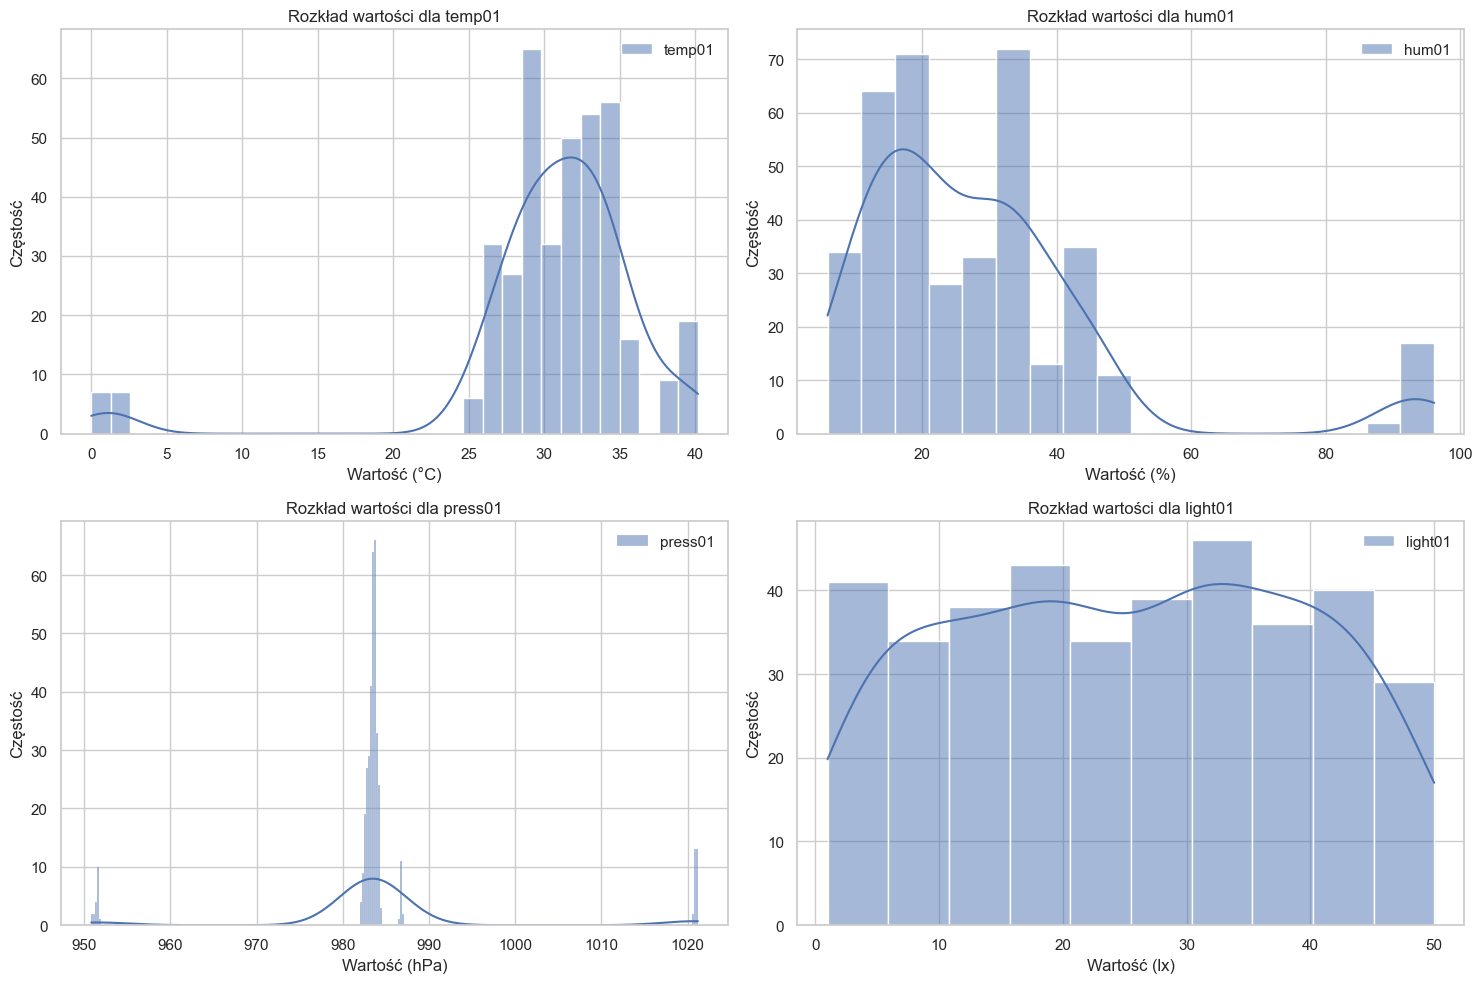

In [10]:
if not df_sensors.empty and 'sensor_id' in df_sensors.columns and len(unique_sensor_ids) > 0:
    print("\nGenerowanie histogramów rozkładu wartości...")
    num_cols = 2  # Liczba kolumn w siatce subplotów
    num_rows = (len(unique_sensor_ids) + num_cols - 1) // num_cols # Obliczenie potrzebnej liczby wierszy

    fig_height = num_rows * 5
    if fig_height < 5: fig_height = 5
    if fig_height > 20: fig_height = 20

    plt.figure(figsize=(15, fig_height))

    for i, sensor_id_val in enumerate(unique_sensor_ids):
        plt.subplot(num_rows, num_cols, i + 1)
        sensor_values = df_sensors[df_sensors['sensor_id'] == sensor_id_val]['value']

        if not sensor_values.empty:
            unit = df_sensors[df_sensors['sensor_id'] == sensor_id_val]['unit'].iloc[0] if 'unit' in df_sensors.columns else ''
            sns.histplot(sensor_values, kde=True, label=sensor_id_val) # kde=True dodaje estymację gęstości jądra
            plt.title(f"Rozkład wartości dla {sensor_id_val}")
            plt.xlabel(f"Wartość ({unit})")
            plt.ylabel("Częstość")
            plt.legend()
        else:
             plt.title(f"Brak danych dla {sensor_id_val}")

    plt.tight_layout()
    plt.show()
else:
    print("Nie można wygenerować histogramów. Niewystarczające dane.")

### 6.3 Wykresy Pudełkowe (Box Plots) do Porównania Rozkładów Wartości Czujników


Generowanie wykresów pudełkowych...


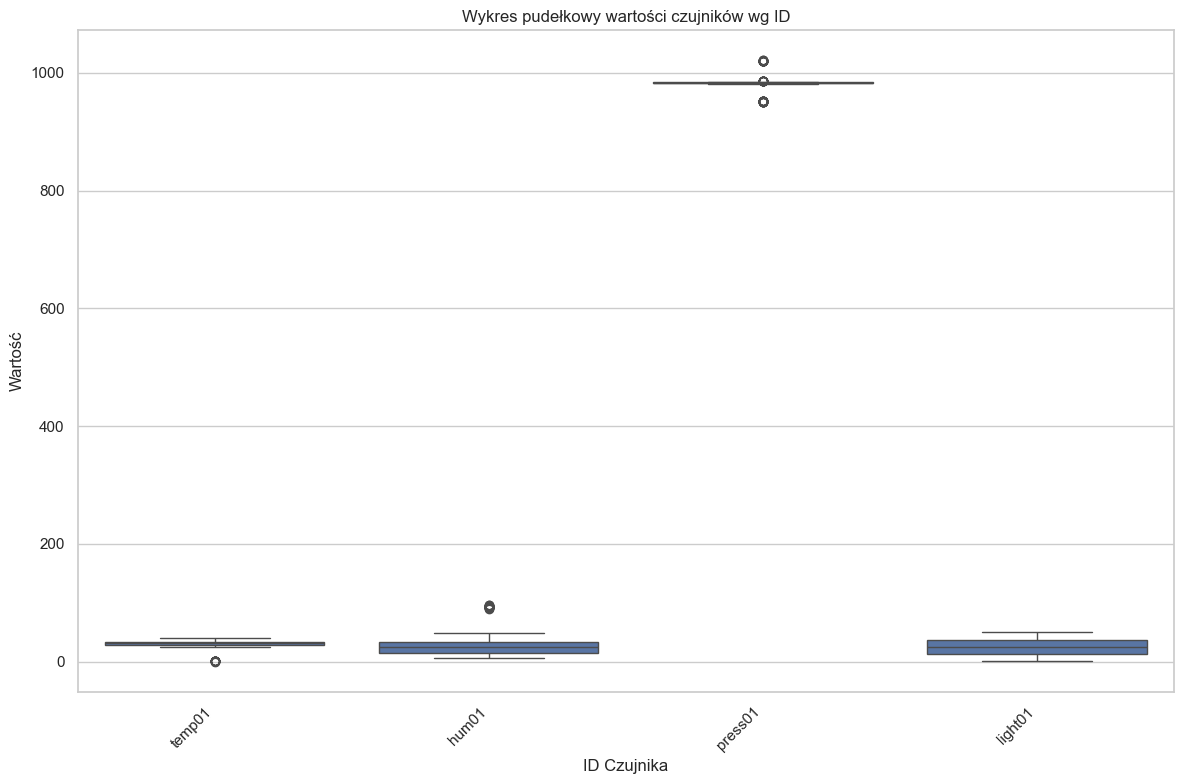


Generowanie wykresów pudełkowych pogrupowanych po jednostkach...


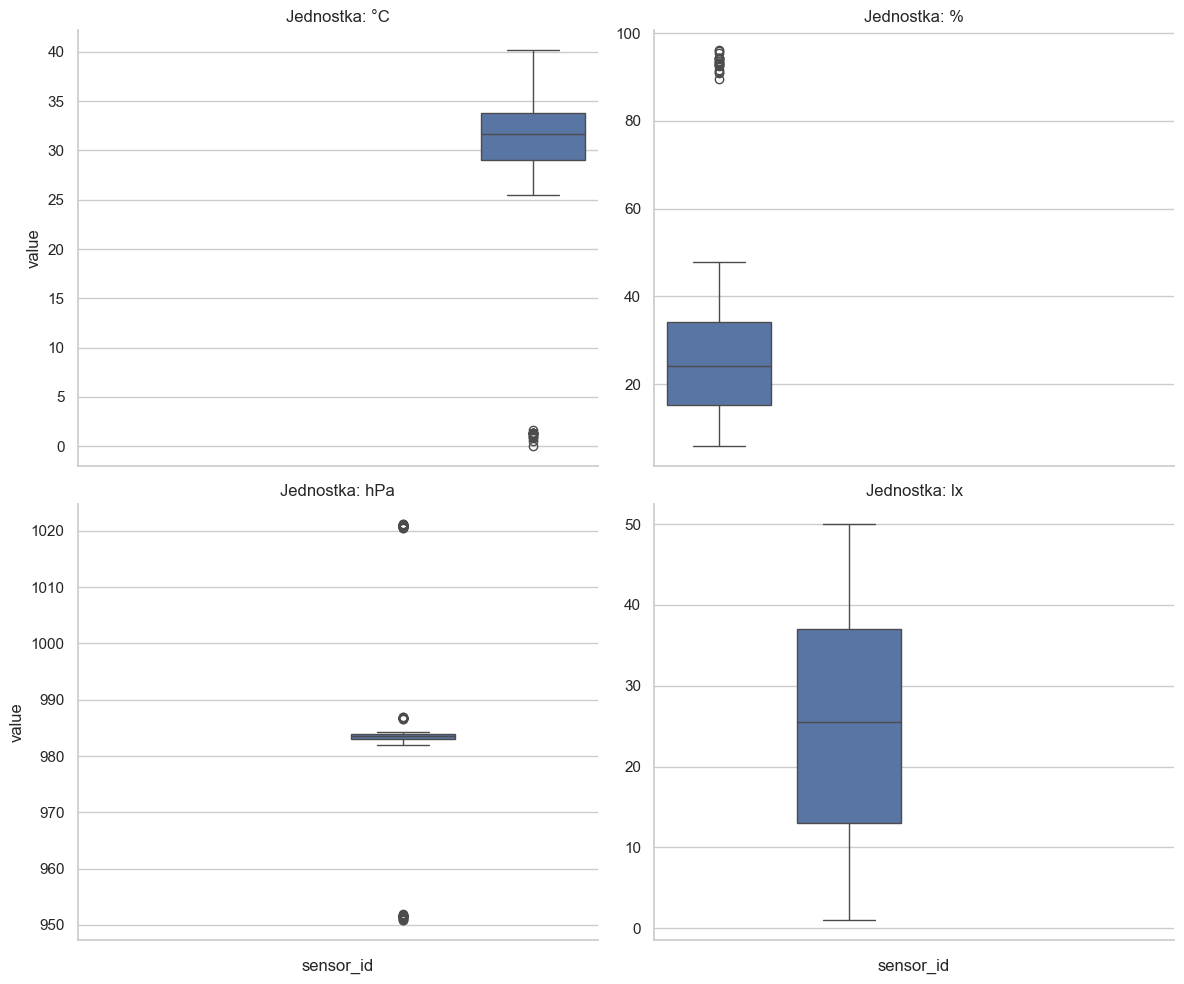

In [12]:
if not df_sensors.empty and 'sensor_id' in df_sensors.columns and 'value' in df_sensors.columns:
    print("\nGenerowanie wykresów pudełkowych...")
    # Wykresy pudełkowe są bardziej sensowne, gdy czujniki mierzą porównywalne wielkości
    # lub gdy chcemy zobaczyć zakresy. Jeśli jednostki są bardzo różne,
    # bezpośrednie porównanie na jednym wykresie może być mylące bez normalizacji.

    # Prosty boxplot dla wszystkich czujników na jednym wykresie (może wymagać dostosowania)
    plt.figure(figsize=(12, 8))
    # Używamy reset_index(), aby 'sensor_id' i 'value' były dostępne jako kolumny
    sns.boxplot(x='sensor_id', y='value', data=df_sensors.reset_index())
    plt.title("Wykres pudełkowy wartości czujników wg ID")
    plt.xlabel("ID Czujnika")
    plt.ylabel("Wartość")
    plt.xticks(rotation=45, ha='right') # Lepsze wyświetlanie etykiet osi X
    plt.tight_layout()
    plt.show()

# Alternatywa: Wykresy pudełkowe pogrupowane po jednostkach, jeśli są różne
    if 'unit' in df_sensors.columns and len(df_sensors['unit'].unique()) > 1:
        print("\nGenerowanie wykresów pudełkowych pogrupowanych po jednostkach...")
        try:
            # Sprawdzenie, czy są dane do wyświetlenia
            df_for_facet = df_sensors.reset_index().dropna(subset=['value', 'sensor_id', 'unit']) # Przygotowanie danych raz
            if not df_for_facet.empty:
                 g = sns.FacetGrid(df_for_facet,
                                   col="unit", sharey=False, height=5, aspect=1.2, col_wrap=2)
                 # ZMIANA TUTAJ:
                 current_order = sorted(list(unique_sensor_ids)) if len(unique_sensor_ids) > 0 else None
                 g.map(sns.boxplot, "sensor_id", "value", order=current_order)
                 g.set_titles("Jednostka: {col_name}")
                 g.set_xticklabels(rotation=45, ha='right')
                 plt.tight_layout()
                 plt.show()
            else:
                print("Brak wystarczających danych (po usunięciu NaN) do stworzenia FacetGrid.")
        except Exception as e:
            print(f"Wystąpił błąd podczas tworzenia FacetGrid: {e}")


else:
    print("Nie można wygenerować wykresów pudełkowych. Niewystarczające dane.")